<a href="https://colab.research.google.com/github/ekqlsrla/ESAA/blob/main/HW/0415_CH03_1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[파이썬 머신러닝 완벽 가이드]**

#**CH 03 - 평가**

1. 성능평가 지표 

  1) 회귀 : 실제값과 예측값의 오차 평균에 기반

  2) 분류 : 일반적으로는 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는 가에 기반
     -> 단순한 평가로 **잘못된 결과**에 빠질수 있음
     - 정확도(Accuracy)
     - 오차행렬 (Confusion Matrix)
     - 정밀도 (Precision)
     - 재현율(Recall)
     - F1 스코어
     - ROC AUC

---
## 01. 정확도 (Accuracy)
: 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

    정확도 (Accuracy) = 예측결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
                      = (TN + TP) / (TN + FP + FN + TP)



In [22]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator) :
  def fit(self,X,y = None) :
   pass
#predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.

  def predict(self,X) :
    import numpy as np
    pred = np.zeros((X.shape[0],1))
    for i in range (X.shape[0]) :
      if X['Sex'].iloc[i] == i :
        pred[i] = 0
      else :
        pred[i] = 1
    return pred

In [23]:
## 생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

## Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

## 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

## Label Encoding 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

## 앞에서 실행한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#원본 데이터를 재로딩, 데이터 가공, 학습 데이터.테스트 데이터 분할

titanic_df = pd.read_csv('/content/drive/MyDrive/DATA/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train,X_test, y_train,y_test = train_test_split(X_titanic_df,y_titanic_df,test_size = 0.2,random_state=0)

In [25]:
myclf = MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는 : {0:4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는 : 0.391061


In [26]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator) :
    def fit(self,X,y) :
      pass
  #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X) :
      return np.zeros( (len(X),1),dtype = bool)
  #사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST데이터 로딩

    digits = load_digits()

  #digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
    y = (digits.target == 7).astype(int)
    X_train,X_test,y_trian,y_test = train_test_split(digits.data,y,random_state = 11)

In [27]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기 : (179,)
테스트 세트 레이블 0과 1의 분포도
0    110
1     69
Name: Survived, dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.615


---
## 02. 오차 행렬
: 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
* **TN**는 예측값을 Negative 값 **0으로 예측**했고 실제 값 역시 **Negative 값 0**
* **FP**는 예측값을 Positive 값 **1로 예측**했는데 실제 값은 **Negative 값 0**
* **FN**은 예측값을 Negative 값 **0으로 예측**했는데 실제 값은 **Positive 값 1**
* **TP**는 예측값을 Positive 값 **1로 예측**했는데 실제 값 역시 **Postitive 값 1**

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,fakepred)

array([[110,   0],
       [ 69,   0]])

---
## 03. 정밀도와 재현율

: Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표

### 1.  **정밀도 = TP / (FP + TP)**
: 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

  1) **정밀도가 중요한 지표인 경우** : 실제** Negative음성**인 데이터 예측을 **Positive 양성으로 잘못 판단**하게 되면 업무상 큰 영향이 발생하는 경우

### 2. **재현율 = TP / (FN + TP)**
: 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율

  1) **재현율이 중요 지표인 경우** : 실제 **Positive 양성** 데이터를 **Negative로 잘못 판단**하게 되면 업무상 큰 영향이 발생하는 경우

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred) :
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:4f}, 정밀도 : {1:4f}, 재현율 : {2:4f}'.format(accuracy,precision,recall))

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torchvision import transforms

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/drive/MyDrive/DATA/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df,y_titanic_df,test_size = 0.2,random_state = 11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.849162, 정밀도 : 0.774194, 재현율 : 0.786885


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### **3. 정밀도/ 재현율 트레이드 오프**

: 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움.

1) `predict_proba()` | 개별 데이터 별로 예측 확률을 반환
  - 입력 파라미터 : 테스트 피처 데이터 세트 입력
  - 반환 값 : 개별 클래스의 예측확률을 mxn 형태로 반환

In [31]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()의 결과 Shape : {0}".format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n :',pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()의 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 : [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [32]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]

#X의 개별 원소들이 threshold 값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [33]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.849162, 정밀도 : 0.774194, 재현율 : 0.786885


* 임곗값을 낮추면 **재현율 값**이 올라가고 **정밀도**가 떨어짐
  
-> 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 되므로 임곗값을 낮출수록 True값이 많아짐

In [35]:
#Binarizer의 threshold 설정값을 0.4로 설정

custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.832402, 정밀도 : 0.718310, 재현율 : 0.836066


* 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

In [37]:
threshold = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds) :
    #thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
    for custom_threshold in thresholds :
      binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
      custom_predict = binarizer.transform(pred_proba_c1)
      print('임곗값:', custom_threshold)
      get_clf_eval(y_test,custom_predict)


get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),threshold)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.832402, 정밀도 : 0.718310, 재현율 : 0.836066
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.849162, 정밀도 : 0.765625, 재현율 : 0.803279
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.849162, 정밀도 : 0.774194, 재현율 : 0.786885
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.865922, 정밀도 : 0.836364, 재현율 : 0.754098
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.877095, 정밀도 : 0.882353, 재현율 : 0.737705


`precision_recall_curve()` | 임곗값 변화에 따른 평가 지표 값
- 입력 파라미터 : y_true (실제 클래스값 배열), probas_pred (Positive 칼럼의 예측 확률 배열 )
- 반환 값 : 정밀도 (임곗값별 정밀도 값을 배열로 반환), 재현율(임곗값별 재현율 값을 배열로 반환)

In [39]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape :', thresholds.shape)

#반환된 임계값 배열 로우가 147이므로 샘플로 10건만 추출하되, 임곗값을 15step으로 추출.
thr_index = np.arange(0,thresholds.shape[0],15)
print('샘플 추출을 위한 임계값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index],2))

#15 step 다위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도 : ',np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율 :', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape : (143,)
샘플 추출을 위한 임계값 배열의 index 10개 : [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 : [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도 :  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율 : [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


* API를 이용해 정밀도와 재현율 곡선 시각화

([<matplotlib.axis.XTick at 0x7f906b732250>,
 <a list of 10 Text major ticklabel objects>)

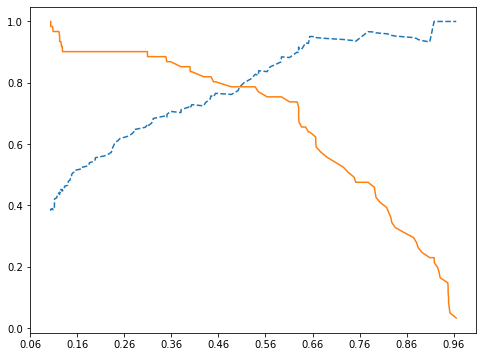

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure(figsize = (8,6))
threshold_boundary = thresholds.shape[0]
plt.plot(thresholds, precisions[0:threshold_boundary],linestyle = '--',label = 'precision')
plt.plot(thresholds,recalls[0:threshold_boundary],label = 'recall')

start,end = plt.xlim()
plt.xticks(np.round(np.arange(start,end,0.1),2))

### 4.정밀도와 재현율의 맹점

  1) 정밀도가 100%가 되는 방법
  : 확실한 기준이 되는 경우만 Positive로 예측하고 **나머지는 모두 Negative**로 예측

  2) 재현율이 100%가 되는 방법
  : **모든** 데이터를 **Positive**로 예측

---
## 04. F1스코어

: 정밀도와 재현율을 **결합한 지표**로, 어느 한 쪽으로 **치우치지 않는 수치**를 나타낼 때 상대적으로 **높은 값** 가짐

  1) `f1_score()` API 사용

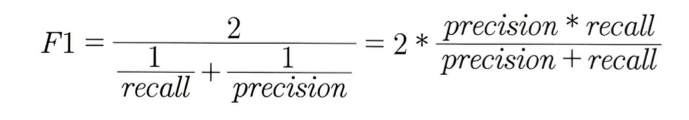

In [42]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test,pred)
print('F1 스코어: {0:4f}'.format(f1))

F1 스코어: 0.780488


In [45]:
def get_clf_eval(y_test,pred) :
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)

  #F1 스코어 추가
  f1 = f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도 : {0:4f}, 정밀도 : {1:4f}. 재현율 : {2:4f}, F1 : {3:4f}'.format(accuracy,precision, recall,f1))

thresholds = [0.4,0.45,0.50,0.55,0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.832402, 정밀도 : 0.718310. 재현율 : 0.836066, F1 : 0.772727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.849162, 정밀도 : 0.765625. 재현율 : 0.803279, F1 : 0.784000
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.849162, 정밀도 : 0.774194. 재현율 : 0.786885, F1 : 0.780488
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.865922, 정밀도 : 0.836364. 재현율 : 0.754098, F1 : 0.793103
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.877095, 정밀도 : 0.882353. 재현율 : 0.737705, F1 : 0.803571


## 05. ROC 곡선과 AUC

1) **ROC(Receiver Operation Characteristic Curve)** : FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는 지를 나타내는 곡선

- **TPR = 민감도** : 실제값 **Positive**가 정확히 예측돼야 하는 수준
- **TNR = 특이성** : 실제값 **Negative**가 정확히 예측돼야 하는 수준
  - TNR = TN / (FP + TN)

- ROC 곡선이 **가운데 직선**에 **가까울수록 성능이 떨어지는 것**

  (1) FPR을 0부터 1까지 변화시키변서 TPR의 변화 값 구함
   -> **분류 결정 임곗값**을 변경
   - FPR을 **0**으로 : **임곗값을 1**로 지정
   - FPR을 **1**로 : TN을 0 = **임곗값을 0**으로 지정
  (2) `roc_curve()` API
  - 입력 파라미터 : y_true(실제 클래스 값) , y_score(Positive칼럼의 예측확률)
  - 반환 값 : fpr,tpr,thresholds

In [48]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측확률을 추출
pred_prob_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs,tprs,thresholds = roc_curve(y_test,pred_proba_class1)

#반환된 임곗값 배열 로우가 47건이므로 샘플로 5 step으로 10건만 추출
#thresholds[0]의 max+1로 임의 설정됨
thr_index = np.arange(1,thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index 10개 :', thr_index)
print('샘플용 10개의 임곗값 :', np.round(thresholds[thr_index],2))

#5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR :', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR :', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개 : [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값 : [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR : [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR : [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


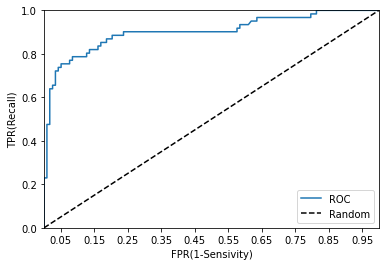

In [50]:
def roc_curve_plot(y_test,pred_proba_c1):
  fprs,tprs,thresholds = roc_curve(y_test,pred_proba_c1)
  plt.plot(fprs,tprs,label = 'ROC')
  plt.plot([0,1],[0,1],'k--',label = 'Random')

  start,end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensivity)')
  plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test,pred_proba[:,1])

2) **AUC(Area Under Curve)** : ROC 곡선 밑의 면적을 구한 것으로서 **1에 가까울수록 좋은 수치**
-> **FPR**이 작은 상태에서 얼마나 큰 **TPR**을 얻을 수 있느냐가 관건

In [54]:
def get_clf_eval(y_test,pred=None,pred_proba = None) :
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 = f1_score(y_test,pred)
  #ROC_AUC
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:4f}, 정밀도 : {1:4f}, 재현율 : {2:4f},F1 : {3:4f}, AUC :{4:4f}'.format(accuracy,precision,recall,f1,roc_auc))